In [32]:
import os
import numpy as np
import imageio
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import voxelmorph as vxm
from voxelmorph.tf.layers import SpatialTransformer
import cv2
import numpy as np
from scipy.ndimage import zoom


In [ ]:
def resize_volume(vol, target_shape):
    """Resize a 3D volume (Z, Y, X) to target_shape (Z, Y, X), allowing distortion."""
    z, y, x = vol.shape
    tz, ty, tx = target_shape

    resized_slices = [cv2.resize(vol[i], (tx, ty), interpolation=cv2.INTER_LINEAR)
                      for i in range(z)]
    stack = np.stack(resized_slices, axis=0)  

    if z != tz:
        zoom_factor = (tz / z, 1.0, 1.0)
        stack = zoom(stack, zoom_factor, order=1)

    return stack

In [34]:
def load_png_volume(folder_path, target_shape=(160,192,224)):
    files = sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith('.png')
    ])

    if len(files) == 0:
        print(f"No PNG files found in: {folder_path}")
        return None

    print(f"Found {len(files)} PNG slices in: {folder_path}")

    slices = [imageio.imread(os.path.join(folder_path, f)) for f in files]
    volume = np.stack(slices, axis=0).astype(np.float32)

    volume = np.clip(volume, 0, np.percentile(volume, 99))
    volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-5)

    volume = resize_volume(volume, target_shape)
    print("Resized volume shape:", volume.shape)
    return volume


In [35]:
MODEL_PATH = "/home/j/FPGA-project/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5"
PNG_FOLDER = "/home/j/FPGA-project/voxelmorph/data/image slice-T1/IXI002-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01" 

In [36]:
fixed = load_png_volume(PNG_FOLDER, target_shape=(160,192,224))

Found 50 PNG slices in: /home/j/FPGA-project/voxelmorph/data/image slice-T1/IXI002-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01


/tmp/ipykernel_93844/4042367800.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  slices = [imageio.imread(os.path.join(folder_path, f)) for f in files]


Resized volume shape: (160, 192, 224)


In [37]:
rng = np.random.RandomState(42)
moving = np.clip(fixed + rng.normal(0, 0.05, fixed.shape), 0, 1)

In [38]:
fx_in = fixed[np.newaxis, ..., np.newaxis]
mv_in = moving[np.newaxis, ..., np.newaxis]

In [39]:
model = vxm.networks.VxmDense.load(
    MODEL_PATH,
    inshape=fixed.shape
)
model 

In [40]:
flow = model.register(mv_in, fx_in)

1/1 [==============================] - 2s 2s/step


In [41]:
transform = vxm.networks.Transform(fixed.shape, nb_feats=1)
warped   = transform.predict([mv_in, flow])[0, ..., 0]

1/1 [==============================] - 0s 357ms/step


In [42]:
nib.Nifti1Image(warped,  np.eye(4)).to_filename("outputs/warped_output.nii.gz")
nib.Nifti1Image(flow,    np.eye(4)).to_filename("outputs/flow_field.nii.gz")

In [43]:
flow_magnitude = np.linalg.norm(flow[0], axis=-1) 

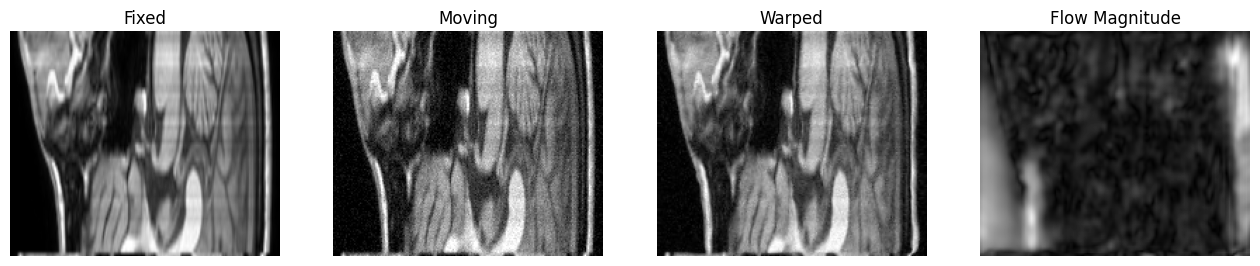

In [44]:
z = fixed.shape[2] // 2
plt.figure(figsize=(16,4))
volumes = [fixed, moving, warped, flow_magnitude]
titles = ["Fixed", "Moving", "Warped", "Flow Magnitude"]

for i, (vol, title) in enumerate(zip(volumes, titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(vol[..., z], cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.show()


In [45]:
#save a onnx model
import onnx
import tf2onnx
import tensorflow as tf
import tf2onnx


MODEL_PATH = "/home/j/FPGA-project/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5"

onnx_model = tf2onnx.convert.from_keras(model, output_path="outputs/vxm_dense_brain_T1_3D_mse.onnx")



2025-05-12 15:01:53.712770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-12 15:01:53.717446: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-05-12 15:01:53.719285: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-05-12 15:01:53.721155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-12 15:01:53.721210: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/